In [368]:
import pandas as pd
import numpy as np  # Make sure NumPy is imported at the top
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras
import torch
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [369]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [370]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [371]:
df['TotalCharges']=df['TotalCharges'].str.replace(' ','0.0').astype('float')

In [372]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [373]:
df.drop(['customerID'], axis=1, inplace=True)

In [374]:
df.isna().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


customer below 18 years with company are leaving


for monthly charges greater than 80 there is more chance of leaving the service

<Axes: xlabel='tenure', ylabel='Churn'>

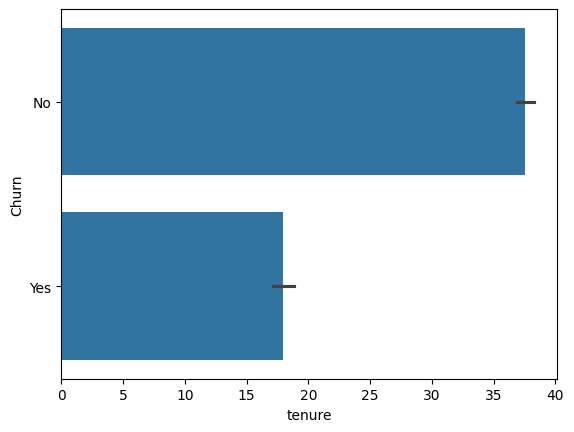

In [375]:
sns.barplot(x='tenure', y='Churn', data=df)

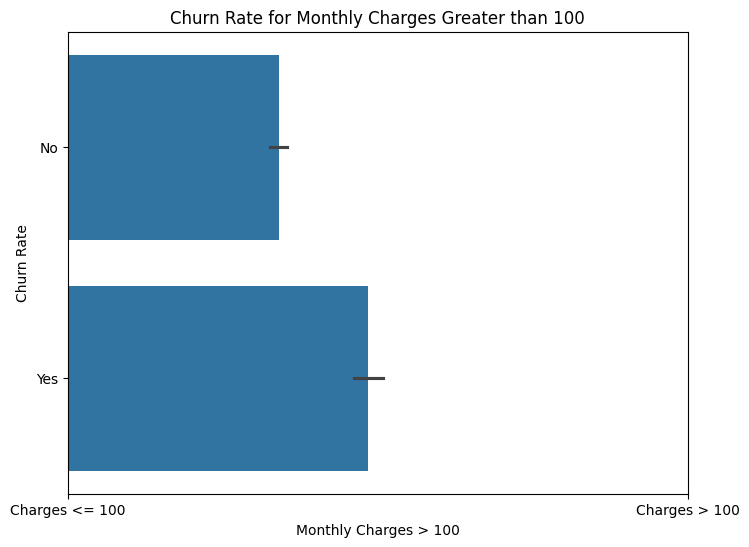

In [376]:
df['ChargesGreaterThan100'] = df['MonthlyCharges'] > 80

# Create a barplot to visualize the relationship
plt.figure(figsize=(8, 6))
sns.barplot(x='ChargesGreaterThan100', y='Churn', data=df)
plt.title('Churn Rate for Monthly Charges Greater than 100')
plt.xlabel('Monthly Charges > 100')
plt.ylabel('Churn Rate')
plt.xticks([0, 1], ['Charges <= 100', 'Charges > 100'])  # Set custom x-axis labels
plt.show()

In [377]:
df['SeniorCitizen'].value_counts()

,count
SeniorCitizen,
0,5901
1,1142


below plot shows that senior who have high monthly charges are likely to leave

senior citizens have a significantly higher churn rate (41.7%) compared to non-senior citizens (23.6%).


In [378]:
df[df['Churn'] == 'Yes'].groupby('SeniorCitizen')['Churn'].count()/df.groupby('SeniorCitizen')['Churn'].count()

,Churn
SeniorCitizen,
0,0.236062
1,0.416813


<Axes: xlabel='SeniorCitizen', ylabel='MonthlyCharges'>

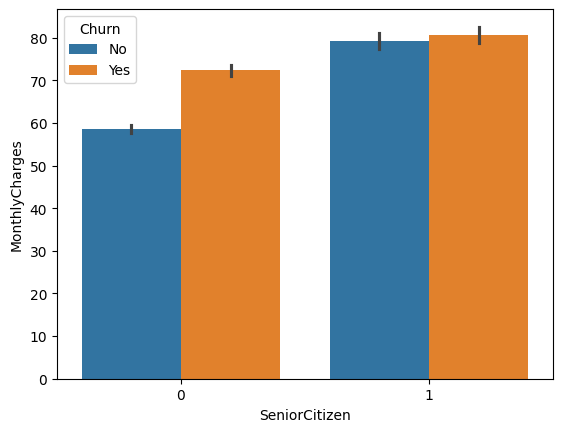

In [379]:
sns.barplot(x='SeniorCitizen', y='MonthlyCharges',hue='Churn', data=df)

In [380]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [381]:
df.drop(['ChargesGreaterThan100'], axis=1, inplace=True)

In [382]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


in our observation This suggests that customers without partners are more likely to churn.



In [383]:
df['Partner'].value_counts()

,count
Partner,
No,3641
Yes,3402


In [384]:
df.groupby('Churn')['Partner'].value_counts()

Churn  Partner
No     Yes        2733
       No         2441
Yes    No         1200
       Yes         669
Name: count, dtype: int64

Churn rate without dependents: 1543 / (1543 + 3390) ≈ 0.313 or 31.3%
Churn rate with dependents: 326 / (326 + 1784) ≈ 0.154 or 15.4%

In [385]:
df.groupby('Churn')['Dependents'].value_counts()

Churn  Dependents
No     No            3390
       Yes           1784
Yes    No            1543
       Yes            326
Name: count, dtype: int64

In [386]:
ob = df.select_dtypes(include='object').columns
ob

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

customers without parters are more tend to leave compared to customer with partner
same with dependents
compared to others fiberoptics internrt services are more likely to leave


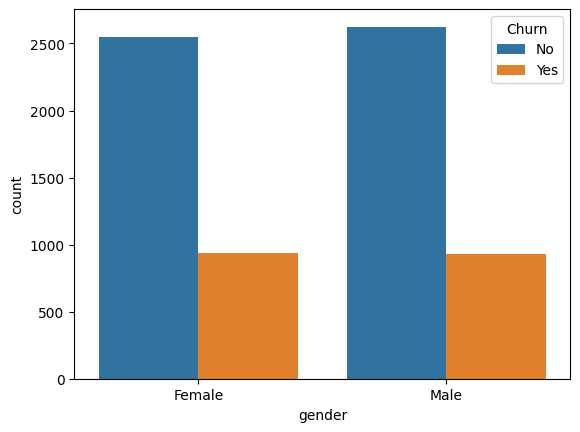

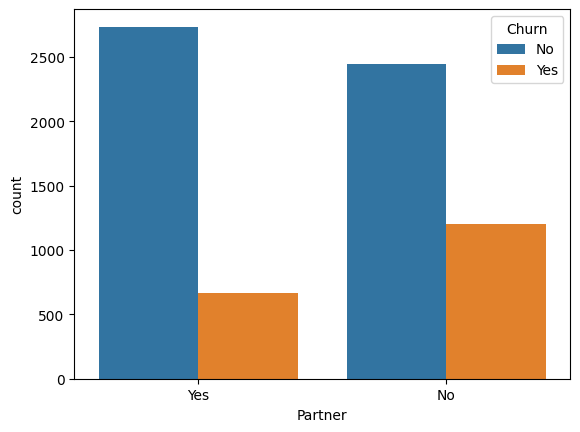

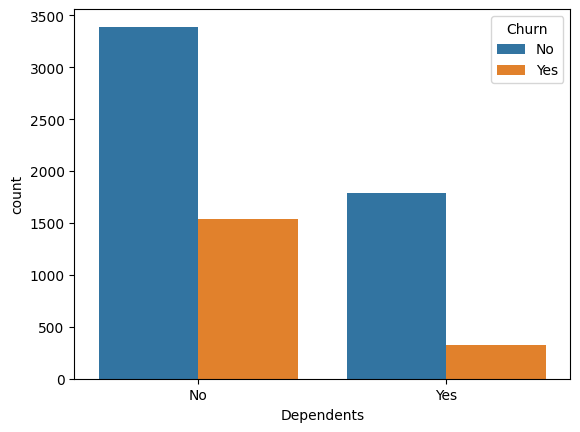

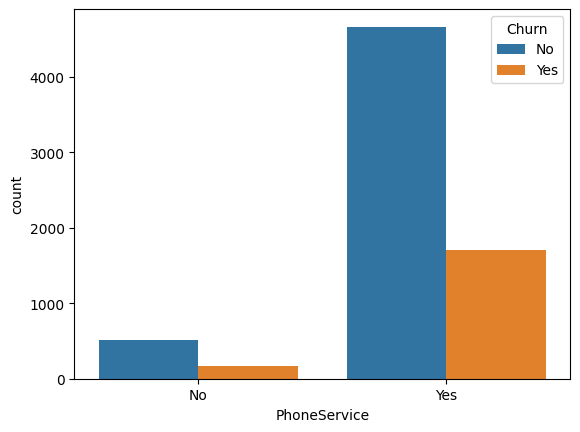

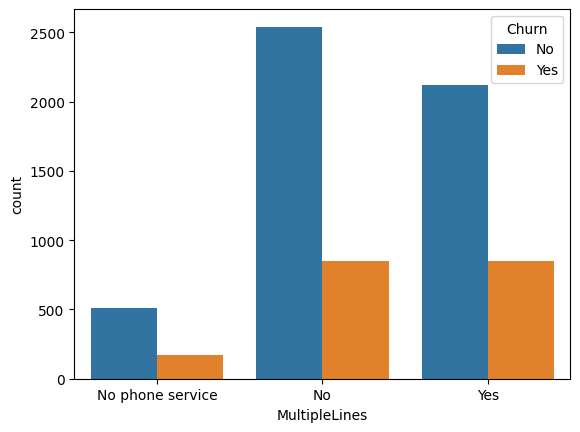

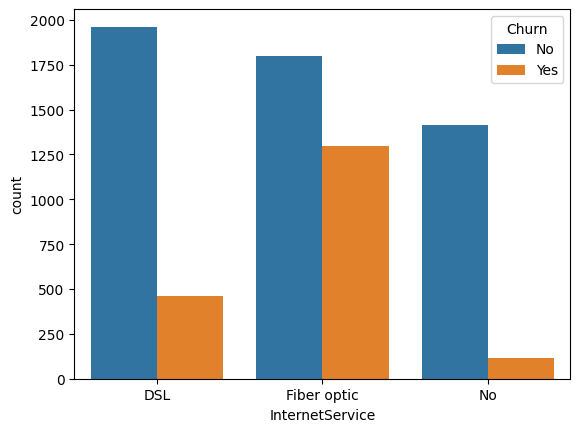

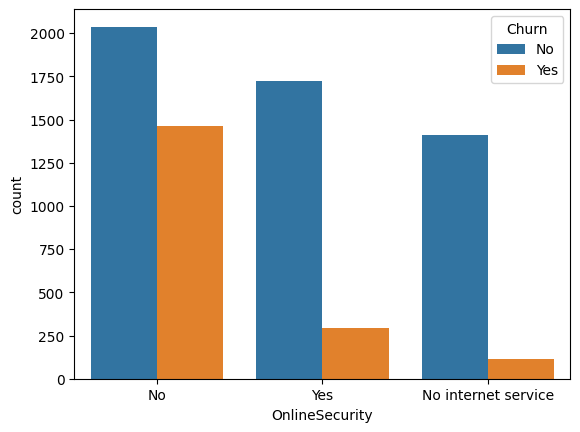

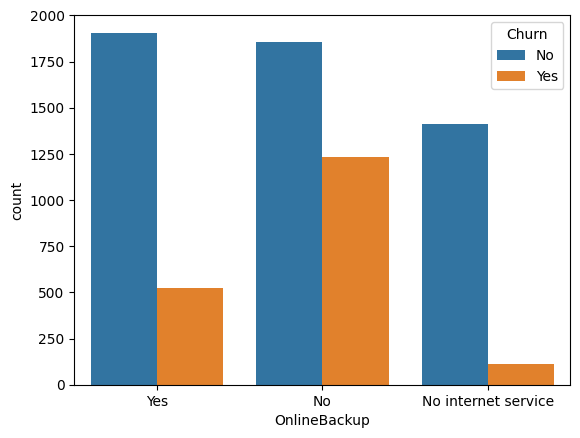

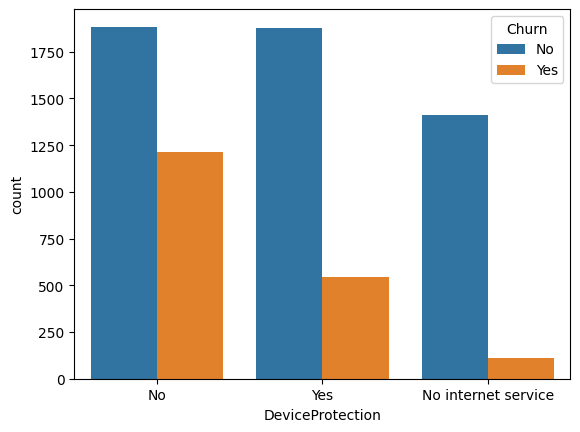

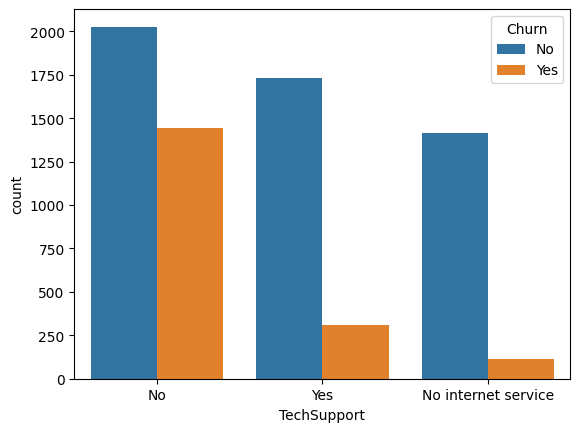

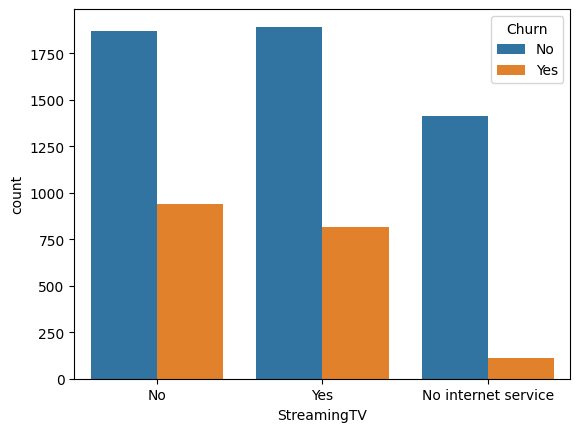

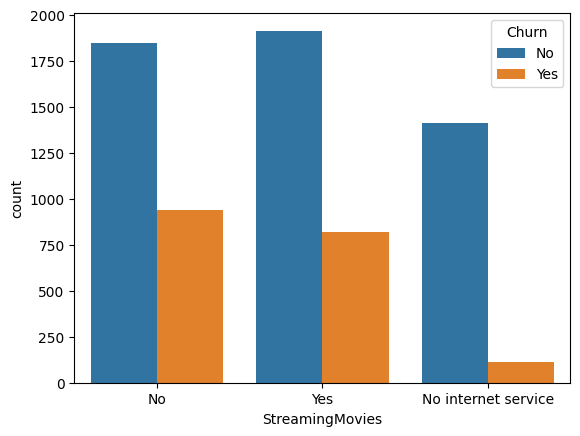

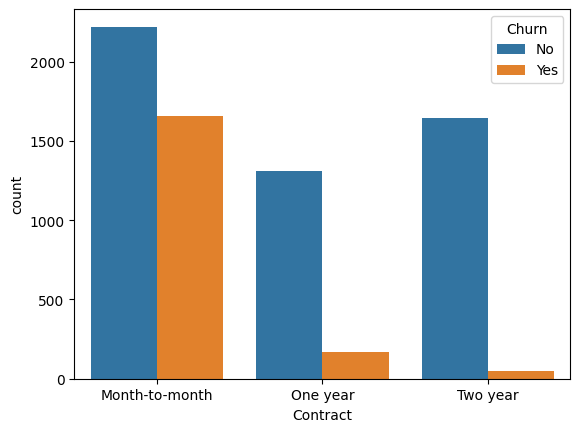

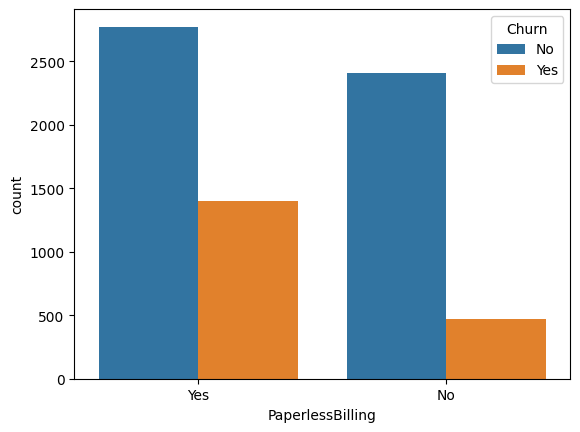

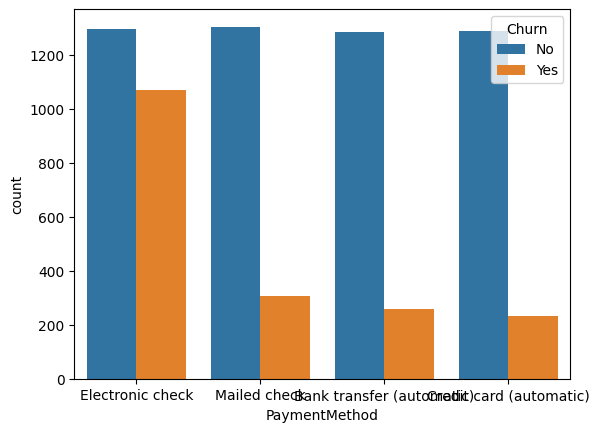

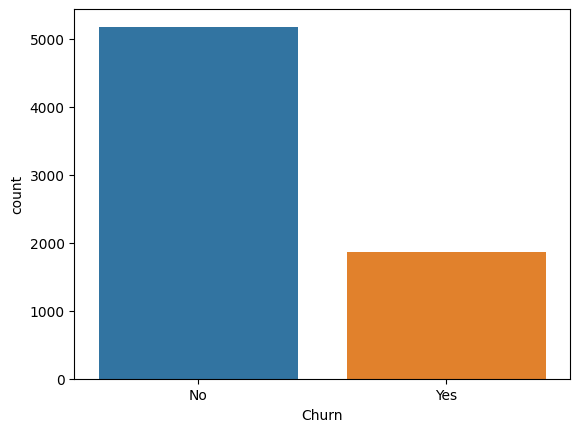

In [387]:
for i in ob:
  sns.countplot(x=df[i],hue=df['Churn'],data=df)
  plt.show()

electronic check payment method are likely to leave
and in the paperless biling i obsereved that most customers that left are in paperless billing option


month to month payment customers are more likely to leave
customers who doesnt have the techsupport,deviceprotection,Onlinebackup,and online security are most likely to leave

# **Feature Eng**

In [388]:
df['SeniorHighCharges'] = (df['SeniorCitizen'] == 1) & (df['MonthlyCharges'] > 80)


In [389]:
df['Dependents'].value_counts()

,count
Dependents,
No,4933
Yes,2110


In [390]:
df['PartnerAndDependents'] = (df['Partner'] == 'Yes') | (df['Dependents'] == 'Yes')
df['NoPartnerNoDependents'] = (df['Partner'] == 'No') | (df['Dependents'] == 'No')

# Create the 'FamilyStatus' feature
df['FamilyStatus'] = 0  # Initialize to 0
df.loc[df['PartnerAndDependents'], 'FamilyStatus'] = 1  # Set to 1 if PartnerAndDependents is True
#df.loc[df['NoPartnerNoDependents'], 'FamilyStatus'] = 0  # Set to 0 if NoPartnerNoDependents is True (already initialized to 0)

# Drop the intermediate columns if desired
df.drop(['PartnerAndDependents', 'NoPartnerNoDependents'], axis=1, inplace=True)

# Print the value counts of the new feature
print(df['FamilyStatus'].value_counts())

FamilyStatus
1    3763
0    3280
Name: count, dtype: int64


In [391]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,SeniorHighCharges,FamilyStatus
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,False,1
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,False,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,False,0
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,False,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,False,0


In [392]:
columns_to_modify = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                     'DeviceProtection', 'TechSupport', 'StreamingTV',
                     'StreamingMovies']

# Replace values in specified columns
for column in columns_to_modify:
    df[column] = df[column].replace({'No phone service': 'No', 'No internet service': 'No'})

# Verify the changes (optional)
print(df[columns_to_modify].head())

  MultipleLines OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0            No             No          Yes               No          No   
1            No            Yes           No              Yes          No   
2            No            Yes          Yes               No          No   
3            No            Yes           No              Yes         Yes   
4            No             No           No               No          No   

  StreamingTV StreamingMovies  
0          No              No  
1          No              No  
2          No              No  
3          No              No  
4          No              No  


In [393]:
df['StreamingServices'] = df['StreamingTV'] + df['StreamingMovies']

# Map values to desired categories
streaming_mapping = {
    'NoNo': 'No Streaming',
    'NoYes': 'Streaming Movies Only',
    'YesNo': 'Streaming TV Only',
    'YesYes': 'Streaming TV and Movies'
}
df['StreamingServices'] = df['StreamingServices'].map(streaming_mapping)

# Print the value counts of the new feature to check its distribution
print(df['StreamingServices'].value_counts())

StreamingServices
No Streaming               3544
Streaming TV and Movies    1940
Streaming Movies Only       792
Streaming TV Only           767
Name: count, dtype: int64


In [394]:
df.drop(['gender','StreamingTV', 'StreamingMovies'], axis=1, inplace=True)

In [395]:
df.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,SeniorHighCharges,FamilyStatus,StreamingServices
0,0,Yes,No,1,No,No,DSL,No,Yes,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,False,1,No Streaming
1,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,One year,No,Mailed check,56.95,1889.50,No,False,0,No Streaming
2,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,False,0,No Streaming
3,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,One year,No,Bank transfer (automatic),42.30,1840.75,No,False,0,No Streaming
4,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,False,0,No Streaming


In [396]:

# Define bins and labels
bins = [0, 12, 24, 36, 48, 60, float('inf')]
labels = ['0-12 months', '13-24 months', '25-36 months', '37-48 months', '49-60 months', '60+ months']

# Create a new column with tenure bins
df['tenure_group'] = pd.cut(df['tenure'], bins=bins, labels=labels)
# Create a new column for the interaction between 'InternetService' and 'Contract'
df['Internet_Contract_Interaction'] = df['InternetService'] + "_" + df['Contract']
# Combine 'PaymentMethod' and 'PaperlessBilling'
df['PaymentMethod_Paperless'] = df['PaymentMethod'] + "_" + df['PaperlessBilling'].astype(str)
# Drop the original columns that have been transformed or combined


In [397]:
# prompt: compare the tenure and tenuregroup where there are nan in tenure group

# Compare tenure and tenure_group where tenure_group has NaN values
tenure_nan_df = df[df['tenure_group'].isna()]
print(tenure_nan_df[['tenure', 'tenure_group']])


      tenure tenure_group
488        0          NaN
753        0          NaN
936        0          NaN
1082       0          NaN
1340       0          NaN
3331       0          NaN
3826       0          NaN
4380       0          NaN
5218       0          NaN
6670       0          NaN
6754       0          NaN


In [398]:
df['tenure_group'] = df['tenure_group'].fillna('0-12 months')

In [399]:
df = df.drop(['tenure', 'InternetService', 'Contract', 'PaymentMethod', 'PaperlessBilling'], axis=1)


In [400]:
cols =['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'SeniorHighCharges', 'FamilyStatus', 'StreamingServices',
       'tenure_group', 'Internet_Contract_Interaction',
       'PaymentMethod_Paperless']
df = df[cols]

In [404]:
df['tenure_group'].astype('object').value_counts()

,count
tenure_group,
0-12 months,2186
60+ months,1407
13-24 months,1024
25-36 months,832
49-60 months,832
37-48 months,762


In [406]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ==== Step 3: Preprocess ====
# Ordinal Encode categorical features
encoder = OrdinalEncoder()
cat_cols = X_train.select_dtypes(include=['object', 'bool']).columns.tolist()

# Ensure 'tenure_group' is included in cat_cols if it's not already
if 'tenure_group' not in cat_cols:
    cat_cols.append('tenure_group')

X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols])
X_test[cat_cols] = encoder.transform(X_test[cat_cols])

# Standard Scale numeric features
num_cols = ['MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Encode target
y_train = y_train.map({'Yes': 1, 'No': 0})
y_test = y_test.map({'Yes': 1, 'No': 0})

# ==== Step 4: Handle Class Imbalance ====
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

**XGBoost Model**


✅ Best Hyperparameters: {'learning_rate': 0.053, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 650}
✅ Best CV ROC-AUC Score: 0.9326539204763542
✅ Test Accuracy: 0.78708303761533
✅ Test ROC-AUC Score: 0.827192642537911

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.86      0.85      0.85      1035
       Churn       0.60      0.62      0.61       374

    accuracy                           0.79      1409
   macro avg       0.73      0.73      0.73      1409
weighted avg       0.79      0.79      0.79      1409



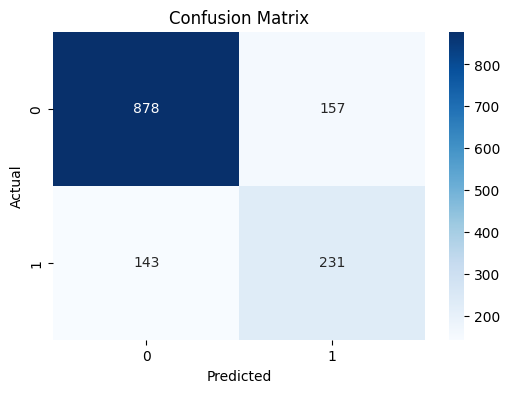

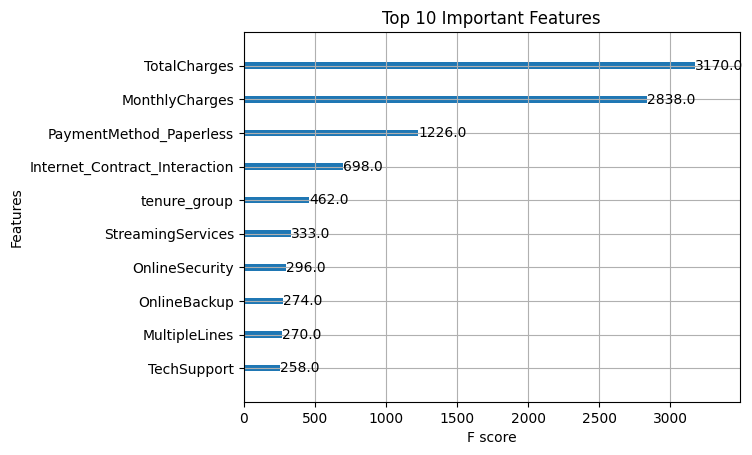

In [414]:

param_grid = {
    'n_estimators': [650,750],
    'max_depth': [4,5,6,7,8,9],
    'min_child_weight': [2,3],
    'learning_rate': [0.05,0.051,0.053]
}

xgb_model = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0,
    n_jobs=1
)

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=cv, scoring='roc_auc', n_jobs=1)
grid_search.fit(X_train_resampled, y_train_resampled)

# ==== Step 6: Evaluation ====
y_pred = grid_search.predict(X_test)
y_proba = grid_search.predict_proba(X_test)[:, 1]

print("✅ Best Hyperparameters:", grid_search.best_params_)
print("✅ Best CV ROC-AUC Score:", grid_search.best_score_)
print("✅ Test Accuracy:", accuracy_score(y_test, y_pred))
print("✅ Test ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# ==== Step 7: Classification Report & Confusion Matrix ====

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No Churn", "Churn"]))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ==== Step 8: Feature Importance ====
xgb.plot_importance(grid_search.best_estimator_, max_num_features=10)
plt.title("Top 10 Important Features")
plt.show()


Threshold: 0.3
Classification Report:
              precision    recall  f1-score   support

    No Churn       0.90      0.74      0.81      1035
       Churn       0.52      0.76      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.75      0.76      1409

Test Accuracy: 0.7487579843860894
--------------------------------------------------


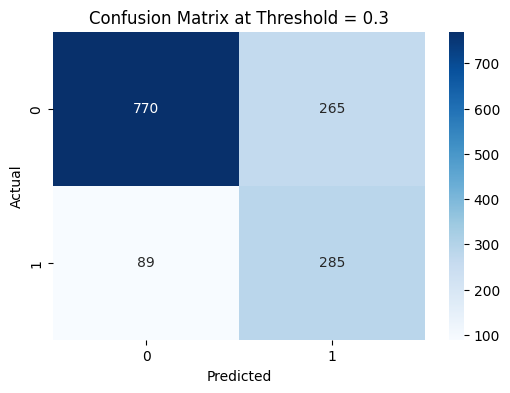

Threshold: 0.4
Classification Report:
              precision    recall  f1-score   support

    No Churn       0.88      0.80      0.84      1035
       Churn       0.55      0.69      0.61       374

    accuracy                           0.77      1409
   macro avg       0.72      0.74      0.72      1409
weighted avg       0.79      0.77      0.78      1409

Test Accuracy: 0.7700496806245565
--------------------------------------------------


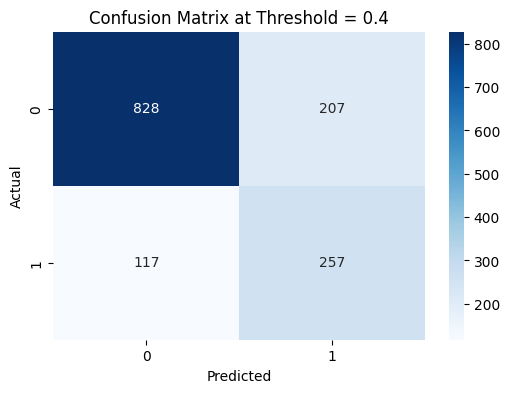

Threshold: 0.5
Classification Report:
              precision    recall  f1-score   support

    No Churn       0.86      0.85      0.85      1035
       Churn       0.60      0.62      0.61       374

    accuracy                           0.79      1409
   macro avg       0.73      0.73      0.73      1409
weighted avg       0.79      0.79      0.79      1409

Test Accuracy: 0.78708303761533
--------------------------------------------------


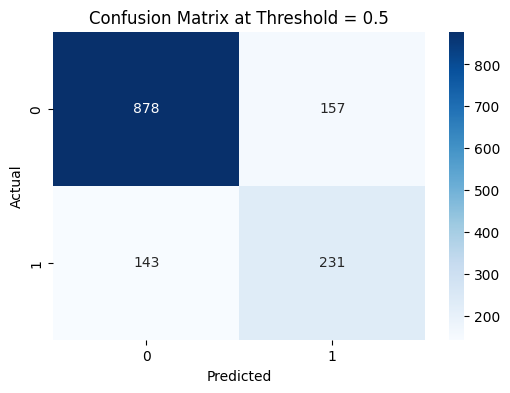

Threshold: 0.6
Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.89      0.86      1035
       Churn       0.63      0.53      0.58       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409

Test Accuracy: 0.7927608232789212
--------------------------------------------------


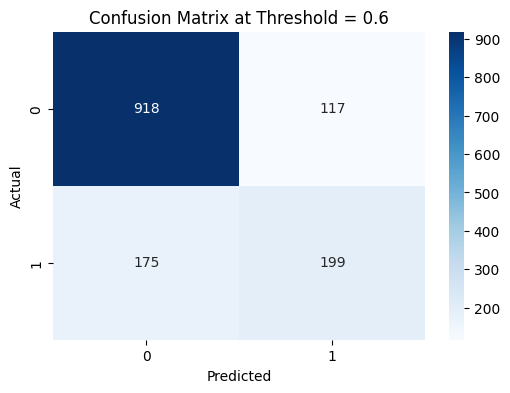

Threshold: 0.7
Classification Report:
              precision    recall  f1-score   support

    No Churn       0.82      0.94      0.88      1035
       Churn       0.72      0.43      0.54       374

    accuracy                           0.80      1409
   macro avg       0.77      0.68      0.71      1409
weighted avg       0.79      0.80      0.79      1409

Test Accuracy: 0.8034066713981547
--------------------------------------------------


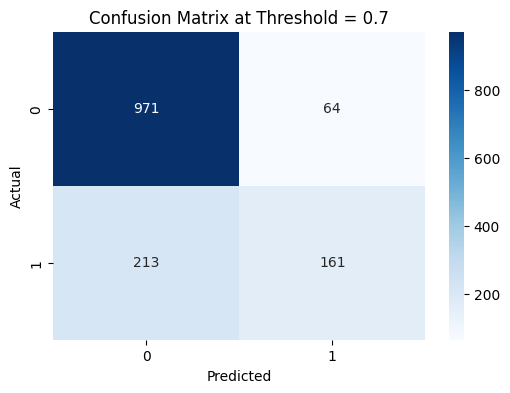

In [415]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Get predicted probabilities (probabilities for class 1, i.e., 'Churn')
y_proba = grid_search.predict_proba(X_test)[:, 1]  # Probabilities for 'Churn' class

# List of thresholds to test
thresholds_to_try = [0.3, 0.4, 0.5, 0.6,0.7]

# Iterate through different thresholds and compute accuracy
for threshold in thresholds_to_try:
    # Apply threshold to convert probabilities to binary predictions
    y_pred_threshold = (y_proba >= threshold).astype(int)

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred_threshold)

    # Print classification report
    print(f"Threshold: {threshold}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_threshold, target_names=["No Churn", "Churn"]))
    print("Test Accuracy:", accuracy)
    print("-" * 50)

    # Optionally: Plot confusion matrix for each threshold
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred_threshold), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix at Threshold = {threshold}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


**Random Forest Model**

✅ Best Parameters: {'max_depth': 18, 'n_estimators': 900}
✅ Test Accuracy: 0.7721788502484032
✅ Test ROC-AUC Score: 0.81937146400062

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.85      0.84      0.84      1035
       Churn       0.57      0.59      0.58       374

    accuracy                           0.77      1409
   macro avg       0.71      0.72      0.71      1409
weighted avg       0.78      0.77      0.77      1409

Test Accuracy: 0.7721788502484032


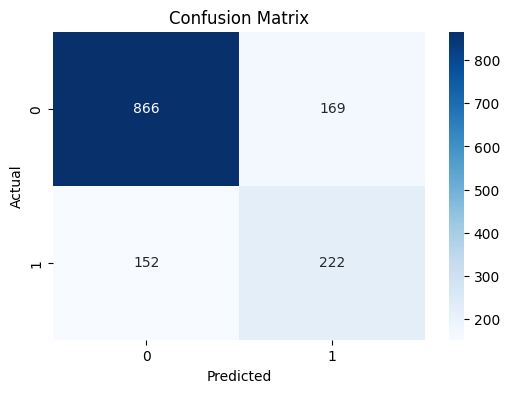

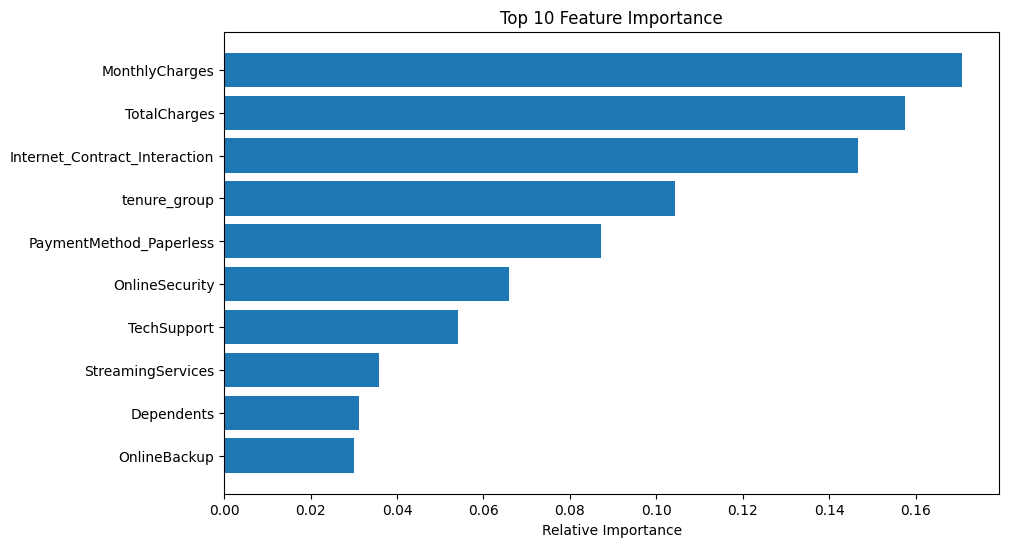

In [408]:

param_grid = {
    'n_estimators': [750,900],
    'max_depth': [18,19],

}

rf_model = RandomForestClassifier(min_samples_split=2, min_samples_leaf=1,
    random_state=42,
    n_jobs=1
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=cv, scoring='roc_auc', n_jobs=1)

grid_search.fit(X_train_resampled, y_train_resampled)

# ==== Step 8: Evaluation ====
y_pred = grid_search.predict(X_test)
y_proba = grid_search.predict_proba(X_test)[:, 1]

print("✅ Best Parameters:", grid_search.best_params_)
print("✅ Test Accuracy:", accuracy_score(y_test, y_pred))
print("✅ Test ROC-AUC Score:", roc_auc_score(y_test, y_proba))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No Churn", "Churn"]))
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# ==== Step 9: Confusion Matrix ====
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ==== Step 10: Feature Importance ====
importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top 10 important features
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importance")
plt.barh(range(10), importances[indices[:10]], align="center")
plt.yticks(range(10), X_train.columns[indices[:10]])
plt.gca().invert_yaxis()
plt.xlabel("Relative Importance")
plt.show()


# ANN

In [409]:

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16,2)   # Output layer with 2 classes

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)

        return x

# Initialize the model, loss function, and optimizer
input_size = X_train_tensor.shape[1]
model = Net(input_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')


# Evaluate the model
with torch.no_grad():
  outputs = model(X_test_tensor)
  _, predicted = torch.max(outputs.data, 1)
  accuracy = accuracy_score(y_test_tensor, predicted)
  print(f"Test Accuracy: {accuracy}")


Epoch [10/100], Loss: 0.6741
Epoch [20/100], Loss: 0.6453
Epoch [30/100], Loss: 0.6104
Epoch [40/100], Loss: 0.5724
Epoch [50/100], Loss: 0.5399
Epoch [60/100], Loss: 0.5199
Epoch [70/100], Loss: 0.5055
Epoch [80/100], Loss: 0.4958
Epoch [90/100], Loss: 0.4886
Epoch [100/100], Loss: 0.4831
Test Accuracy: 0.7423704755145494


In [410]:

# Define the ANN model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_split=0.2)


# Evaluate the model on the training set
_, train_accuracy = model.evaluate(X_train_resampled, y_train_resampled, verbose=0)
print(f"Training Accuracy: {train_accuracy}")

# Evaluate the model on the testing set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int) # Convert probabilities to binary predictions
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Testing Accuracy: {test_accuracy}")


Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6875 - loss: 0.5723 - val_accuracy: 0.5996 - val_loss: 0.8486
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7652 - loss: 0.4828 - val_accuracy: 0.6600 - val_loss: 0.7174
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7664 - loss: 0.4777 - val_accuracy: 0.6691 - val_loss: 0.7123
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7762 - loss: 0.4673 - val_accuracy: 0.6848 - val_loss: 0.6599
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7669 - loss: 0.4763 - val_accuracy: 0.6963 - val_loss: 0.6428
Epoch 6/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7699 - loss: 0.4685 - val_accuracy: 0.7132 - val_loss: 0.6250
Epoch 7/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7816 - loss: 0.4591 - val_accuracy: 0.7271 - val_loss: 0.5910
Epoch 8/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7689 - loss: 0.4624 - val_accuracy: 0.